<a href="https://colab.research.google.com/github/hywkim-private/ALIGNet/blob/main/ALIGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2, wget
from zipfile import ZipFile
import h5py 

from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split


In [ ]:
pip install wget

In [ ]:
#define hyper parameters 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 20
BATCH_SIZE = 10

TARGET_PROPORTION = 0.1
TARGET_PROPORTION_VAL = 0.5
TARGET_PROPORTION_TEST = 0.5

VAL_SIZE = 20
N_CLASS = 10
TEST_SIZE = 20
IMAGE_SIZE =128

#parameters for mask operation
MASK_SIZE = 60
MASK_STRIDE = 20

#parameters for the warp-field/grid
GRID_SIZE = 8


FILE_PATH = '../data/h5files'

In [ ]:
image_url = 'https://drive.google.com/uc?export=download&id=1Vv-Jz1VpI48MOVgK3Hq6ZYrs2NDP-FQ2'
filename = wget.download(image_url)
zf = ZipFile(filename, 'r')
zf.extractall('../data')
zf.close()

In [ ]:
#This class must be fine-tuned after completing the model, so as to be able to read from any h5 input formats
class Load_HDF5(Dataset):
  # if get_all == True, file_path must specifiy a directory, if not, it should specify a file
  # the class will crash if this requirement is not met
  def __init__(self, file_path, get_all = False, transform = None):
    self.path = file_path
    self.transform = transform
    #if filename is None, perform a recursive search over the file directory and retrieve all .h5 files
    p = Path(file_path)
    if get_all == True:
      files = sorted(p.glob('*.h5'))
      data_list = []
      for file in files:
        data_list.append(self.get_file(str(file)))
      self.data = data_list
    else:
      self.data = self.get_file(str(file))

  #given a filepath, return the image object
  def get_file(self, path):
    with h5py.File(path, 'r') as file:
      data = file['dep']
      data = data.get('view1')[:]
      return data
    
  def __getitem__(self, index):
    if len(self.data) <= index:
      print("__getitem__ERROR: index out of range")
      return 
    else:
      x = self.data[index]
      x = x.astype('float32')
      if self.transform:
        x = self.transform(x)
      return x

  def __len__(self):
    return len(self.data)

    
#visualize image given a data loader
def visualize_image(data_loader, plot_size):
  fig, ax = plt.subplots(plot_size, plot_size, figsize=(20,20))
  x = 0
  y = 0
  for i,batch_image in enumerate(data_loader):
    for k,image in enumerate(batch_image):
      image = image.squeeze()
      if x >= plot_size:
        x = 0
        y += 1
      if y >= plot_size:
        return
      ax[x,y].imshow(image, cmap='gray')
      x += 1

   


In [ ]:
ds = Load_HDF5(FILE_PATH, get_all=True, transform=ToTensor())

#split data into train, validation, test sets
TRAIN_SIZE = len(ds)-VAL_SIZE-TEST_SIZE
Trainset, Validset, Testset = random_split(ds,[TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

Trainset_target, Trainset_source = random_split(Trainset, [int(TRAIN_SIZE*TARGET_PROPORTION), int(TRAIN_SIZE*(1-TARGET_PROPORTION))])
Validset_target, Validset_source = random_split(Validset, [int(VAL_SIZE*TARGET_PROPORTION_VAL), int(VAL_SIZE*(1-TARGET_PROPORTION_VAL))])
Testset_target, Testset_source = random_split(Testset, [int(TEST_SIZE*TARGET_PROPORTION_TEST), int(TEST_SIZE*(1-TARGET_PROPORTION_TEST))])

#make dataloaders for targets and sources
train_loader_target = DataLoader(Trainset_target, batch_size=1, shuffle=True)
train_loader_source = DataLoader(Trainset_source, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_target = DataLoader(Validset_target, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_source = DataLoader(Validset_source, batch_size=BATCH_SIZE, shuffle=True)
test_loader_target = DataLoader(Testset_target, batch_size=BATCH_SIZE, shuffle=True)
test_loader_source = DataLoader(Testset_source, batch_size=BATCH_SIZE, shuffle=True)



In [ ]:
#given mask_size, target_size, stride, and target_image, create as many masked target images as possible and return its corresponding dataset
def mask_target_2d(mask_size, stride, target_size, target_image):
  #define parameters to fine-tune the masking operation
  remainder = target_size % mask_size
  max_iter = int(target_size / mask_size)

  #even_remainder denotes whether the remaining pixel after masking the input image is even (default=false)
  even_remainder = False
  if remainder % 2 == 0:
    even_remainder = True
  #convert target image to numpy in order to ease type conversions
  target_image = np.array(target_image)
  starting_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #the current_coordinate denotes the upper-right-most coordinate of the mask 
  current_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #max_coordinate denotes the upper_right-most corner of the target image that the mask can reach
  max_coordinate = [target_size-int(remainder/2),target_size-int(remainder/2)]
  #dataset of masked images
  masked_arr = []
  target_image = target_image.squeeze()
  #the first element of masked data will be the original image
  masked_arr.append(target_image.copy())
  #produce mask images until the mask reaches the upper_right corner of the target image (max_coordinate)
  while (current_coordinate[0] <= max_coordinate[0]) and (current_coordinate[1] <= max_coordinate[1]):
    #turn all areas within the masking target into zero
    masked_image = target_image.copy()
    masked_image[current_coordinate[0]-mask_size:current_coordinate[0],current_coordinate[1]-mask_size:current_coordinate[1]] = 0
    #add the masked image to data array--only if the masked image is different from the original image
    if not np.array_equal(masked_image, target_image):
      masked_arr.append(masked_image)
    #update current_coordinate along the x-axis
    current_coordinate[0] = current_coordinate[0] + stride
    #if the mask reaches the max of the x axis, move up to the y axis 
    if current_coordinate[0] >= max_coordinate[0]:
      current_coordinate[1] = current_coordinate[1] + stride
      current_coordinate[0] = starting_coordinate[0] 

  masked_arr = np.array(masked_arr).squeeze()
  #after all iterations, convert the array data into dataset
  masked_ds = torch.FloatTensor(masked_arr)

  return masked_ds
    
  






In [ ]:
test_image_batch = next(iter(train_loader_target))
test_image = next(iter(test_image_batch))
#test cell for the function mask_target_2d
masked_ds = mask_target_2d(60, 20, 128, test_image)
masked_dl = DataLoader(masked_ds, batch_size=BATCH_SIZE, shuffle=False)

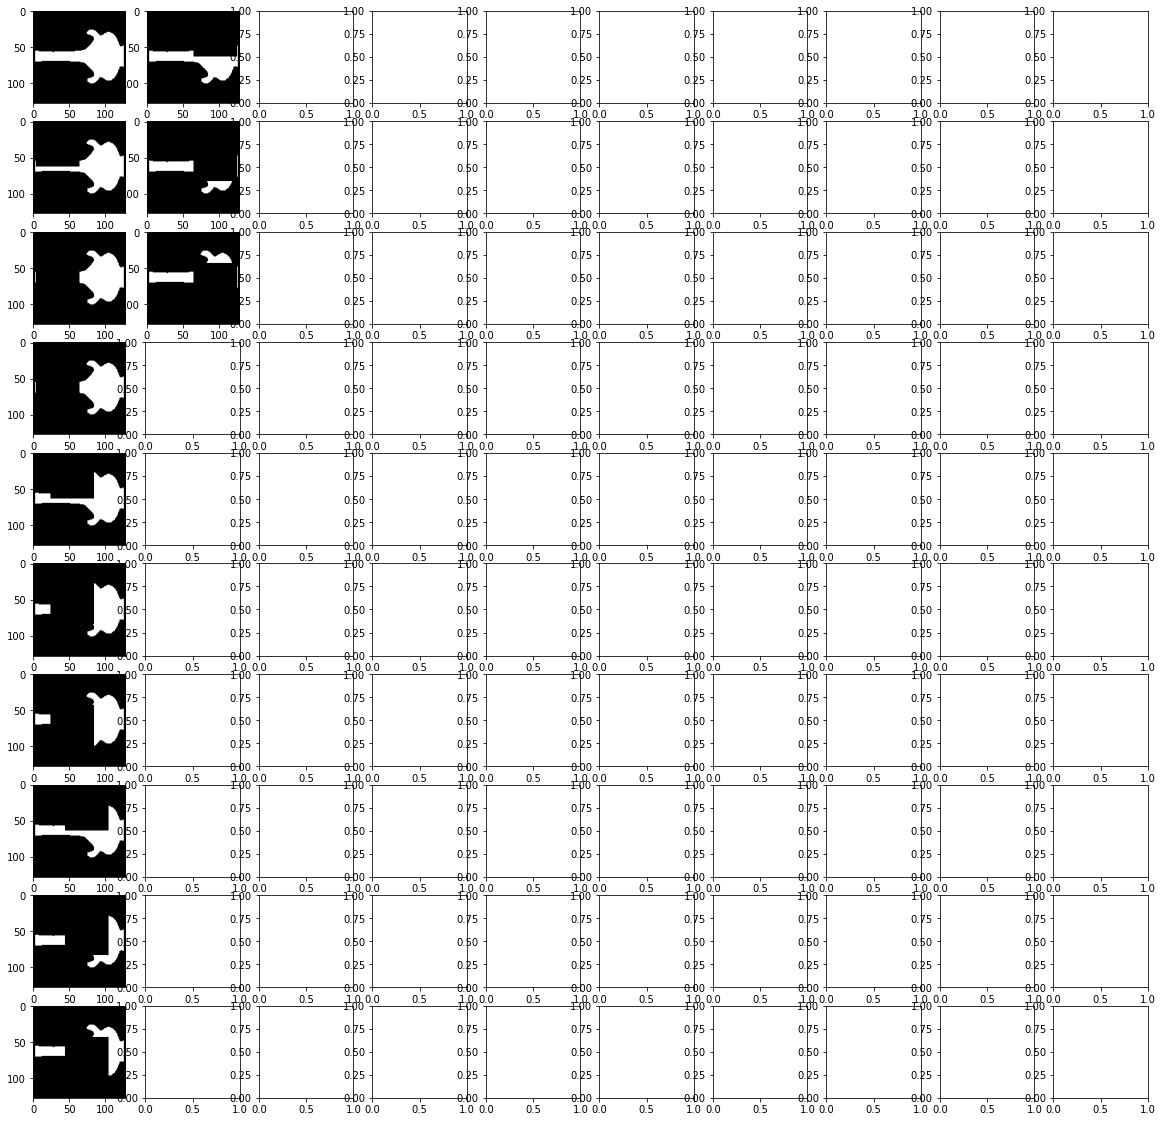

In [ ]:

visualize_image(masked_dl, 10)

In [ ]:
#initialize the differential grid
#the parameter learn offset will define whether or not to learn the offset values during training
def init_grid(grid_size):
  #spacing of the grid
  delta = 2/grid_size
  np_grid = np.arange(grid_size, dtype=float)
  np_grid = np.full_like(np_grid,float(delta))
  ts_grid_x = torch.tensor(np_grid).to(DEVICE)
  ts_grid_y = torch.tensor(np_grid).to(DEVICE)
  ts_grid_x[0] = -1
  ts_grid_y[0] = -1
  diff_i_grid_y, diff_i_grid_x = torch.meshgrid(ts_grid_x,ts_grid_y)

  """  print(f'{diff_i_grid_x},{diff_i_grid_y}')"""  
  diff_grid = torch.stack([diff_i_grid_x, diff_i_grid_y])
  diff_grid = diff_grid.view(2*grid_size*grid_size)
  return diff_grid

#define the alignnet model
def get_conv(grid_size):
  model = nn.Sequential (
      nn.MaxPool2d (2),
      nn.Conv2d (2, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 5),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 2),
      nn.ReLU(),
      nn.MaxPool2d (2),
      nn.Conv2d (20, 20, 5),
      nn.ReLU(),
      
      #we need an Abs() functionality in order to ensure axial monotinicity
      #but will implement it in the network loop for readability 
  )
  return model

#define the model class
class ALIGNet(nn.Module):
    def __init__(self, grid_size):
      super().__init__()
      self.conv = get_conv(grid_size).to(DEVICE)
      self.flatten = nn.Flatten().to(DEVICE)
      self.linear1 = nn.Sequential(nn.Linear(80,20, bias = True),nn.ReLU(),).to(DEVICE)
      self.linear2 = nn.Linear(20, 2*grid_size*grid_size, bias=True).to(DEVICE)
      self.linear2.weights = init_grid(grid_size)
      self.grid_offset_x = torch.tensor(float(0), requires_grad=True).to(DEVICE)
      self.grid_offset_y = torch.tensor(float(0), requires_grad=True).to(DEVICE)
      self.grid_offset_x = nn.Parameter(self.grid_offset_x)
      self.grid_offset_y = nn.Parameter(self.grid_offset_y)
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x



#create and return a 2dimensional nxn grid (returns a vertically-stacked grid of x and y grid)
def get_grid(grid_size):
  grid_x, grid_y = torch.meshgrid(torch.linspace(-1,1,grid_size),torch.linspace(-1,1,grid_size))
  grid = torch.stack(grid_x, grid_y)
  return grid


#define a custom loss function, including the L1 regularization
#the warp field has the input format of Nx2xWxH
def Total_Loss (target_image, warped_image, warp_field, grid_size):
  batch, N,W,H = warped_image.shape
  L2_Loss_f = nn.MSELoss()
  L2_Loss = L2_Loss_f(target_image, warped_image)
  #create the identity grid
  #create the identity differential grid
  np_grid = np.arange(grid_size, dtype=float)
  np_grid = np.full_like(np_grid,float(2/grid_size))
  diff_i_grid_x, diff_i_grid_y = torch.meshgrid(torch.tensor(np_grid),torch.tensor(np_grid))
  diff_i_grid_x = diff_i_grid_x.unsqueeze(dim=0)
  diff_i_grid_y = diff_i_grid_y.unsqueeze(dim=0)
  diff_i_grid_x = diff_i_grid_x.to(DEVICE)
  diff_i_grid_y = diff_i_grid_y.to(DEVICE)
  #calculate the L1_Loss
  L1_Loss_f = nn.L1Loss()
  L_TV_Loss = L1_Loss_f(warp_field[:,0],diff_i_grid_x) + L1_Loss_f(warp_field[:,1],diff_i_grid_y)
  Total_loss = L2_Loss + L_TV_Loss
  return Total_loss

#perform cumsum operation on a 2d batch of inputs
#takes in grid tensors of shape batch x 2 x grid x grid 
#return grid tensors of shape batch x 2 x grid x grid 
def cumsum_2d(model, grid):
  batch_size, dim, grid_1, grid_2 = grid.shape
  grid[:,0,:,0] = -1 + model.grid_offset_x
  grid[:,1,0,:] = -1 + model.grid_offset_y

  Integrated_grid_x = torch.cumsum(grid[:,0], dim = 2) 
  Integrated_grid_y = torch.cumsum(grid[:,1], dim = 1) 

  #print(f'{model.grid_offset_x}, {model.grid_offset_y}')

  Integrated_grid = torch.stack([Integrated_grid_x, Integrated_grid_y])
  Integrated_grid = Integrated_grid.permute([1,0,2,3])

  """print(f'grid: {grid}')"""
  #print(f'Integrated_grid_x: {Integrated_grid_x}, Integrated_grid_y: {Integrated_grid_y}')

  return Integrated_grid

def warp(model, source_image, masked_target, grid_size):
  input_image = torch.stack([source_image, masked_target])
  input_image  = input_image.permute([1,0,2,3])
  #run the network
  output_grid = model.forward(input_image)

  batch, grid = output_grid.shape

  """print(f'shape of output_grid {output_grid.shape}')"""

  output_grid = output_grid.view(batch, 2,grid_size,grid_size)
  output_grid = output_grid.squeeze()
  #enforce axial monotinicity using the abs operation
  output_grid = torch.abs(output_grid)
  #perform the cumsum operation to restore the original grid from the differential grid
  integrated_grid = cumsum_2d(model,output_grid)

  """print(f'shape of Integrated_grid {integrated_grid.shape}')"""

  #Upsample the grid_size x grid_size warp field to image_size x image_size warp field
  #We will use bilinear upsampling
  #Integrated_grid = torch.unsqueeze(Integrated_grid, 0)
  Upsampler = nn.Upsample(size = [IMAGE_SIZE, IMAGE_SIZE], mode = 'bilinear')
  Upsampled_grid = Upsampler(integrated_grid)
  Upsampled_grid = Upsampled_grid.permute(0,2,3,1)
  Upsampled_gird = Upsampled_grid.float()
  #calculate target estimation
  Target_estimate = nn.functional.grid_sample(source_image.unsqueeze(0).permute([1,0,2,3]), Upsampled_grid)
  return output_grid, Target_estimate
   
#run the model for a single epoch
def run_epoch(model, optimizer, source_loader, target_loader, grid_size):
  #we will save the average loss for seperate target images
  Loss_list = []
  for index_target, target_image in enumerate(target_loader):
    #create a masked target loader for a single target
    masked_ds = mask_target_2d(MASK_SIZE, MASK_STRIDE, IMAGE_SIZE, target_image)
    target_image = target_image.to(DEVICE)
    masked_dl = DataLoader(masked_ds, batch_size=BATCH_SIZE, shuffle=False)
    #train the source on each masked images
    for index_masked, masked_target in enumerate(masked_dl):
      #list of loss for each masked_target image
      target_loss = []
      for index_source, source_image in enumerate(source_loader):

        """print(f'shape of source_image { source_image.shape}')
        print(f'shape of masked_target { masked_target.shape}')"""

        #vertically stack target and source images to feed into the model
        source_image = source_image.float().to(DEVICE)
        masked_target = masked_target.float().to(DEVICE)
        source_image = source_image.squeeze(dim=1)

        #break if there isn't enough masked_target left
        if masked_target.shape != source_image.shape:
          break

        #run forward propagation
        output_grid, Target_estimate = warp(model, source_image, masked_target,grid_size)        

        Total_loss = Total_Loss(target_image, Target_estimate, output_grid, grid_size)
        Total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        target_loss.append(Total_loss)
      if target_loss:
        #print(f'Loss for a target: {target_loss}')
        avg_loss_target = sum(target_loss) / len(target_loss)
        Loss_list.append(avg_loss_target)
  return Target_estimate, Loss_list

def run_model(model,source_loader, target_loader, grid_size):
  optimizer = optim.Adam(model.parameters(), lr=1e-5)
  epoch_loss = []
  for i in range(EPOCHS):
    target_estimate, loss_list = run_epoch(model, optimizer, source_loader, target_loader, grid_size)
    avg_epoch_loss = sum(loss_list) / len(loss_list)
    epoch_loss.append(avg_epoch_loss)
    print(f'Loss in Epoch {i}: {avg_epoch_loss}')
  return epoch_loss

#------FROM HERE BELOW WE WILL DEFINE FUNCTIONS REQUIRED FOR VALIDATION-------

#visualize the results given source, target, and target estimate images
def visualize_results(source_image,  target_image, target_estimate):
  batch, _, _ = source_image.shape
  fig, ax = plt.subplots(batch, 3, figsize=(20,20))
  for i in range(batch):
    ax[i,0].title('source_image')
    ax[i,0].imshow(source_image[i], cmap='gray')
    ax[i,1].title('target_image')
    ax[i,1].imshow(target_image[i], cmap='gray')
    ax[i,2].title('target_estimate')
    ax[i,2].imshow(target_estimate[i], cmap='gray')
  return

#given source and target validation  dataloaders, perform all validation operations
def validate(model, source_dl, target_dl, grid_size, visualize = False):
  #we will run everything, save the results, and visualize the images all at once
  if visualize:
    source = []
    target = []
    target_est = []
    for i, target_image in enumerate(target_dl):
      for k, source_image in enumerate(source_dl):
        source_image = source_image.squeeze().to(DEVICE)

        target_image = target_image.squeeze().to(DEVICE)
        output_grid, target_estimate = warp(model, source_image, target_image, grid_size)  
        source_image = source_image.to(torch.device('cpu')).detach().numpy()
        target_image = target_image.to(torch.device('cpu')).detach().numpy()
        target_estimate = target_estimate.squeeze().to(torch.device('cpu')).detach().numpy()
        source.append(source_image)
        target.append(target_image)
        target_est.append(target_estimate)
    for i in range(len(source)):
      source_image = source[i]
      target_image = target[i]
      target_estimate = target_est[i]
      visualize_results(source_image, target_image, target_estimate)


  #TODO: MUST WORK ON INITIALIZING THE GRID VALUES TO A PROPER DIFFERENTIAL GRID



In [ ]:
model = ALIGNet(GRID_SIZE)
e_loss =  run_model(model,train_loader_source, train_loader_target, GRID_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([10, 1, 128, 128])) that is different to the input size (torch.Size([1, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have 

Loss in Epoch 0: 0.8894703388214111
Loss in Epoch 1: 0.8710058927536011
Loss in Epoch 2: 0.8450372815132141
Loss in Epoch 3: 0.8269273638725281
Loss in Epoch 4: 0.8095446825027466
Loss in Epoch 5: 0.7941667437553406
Loss in Epoch 6: 0.7802308201789856
Loss in Epoch 7: 0.7110673189163208
Loss in Epoch 8: 0.6613385081291199
Loss in Epoch 9: 0.6304735541343689
Loss in Epoch 10: 0.6087159514427185
Loss in Epoch 11: 0.5951364040374756
Loss in Epoch 12: 0.5836016535758972
Loss in Epoch 13: 0.5762178301811218
Loss in Epoch 14: 0.5722779631614685
Loss in Epoch 15: 0.5681268572807312
Loss in Epoch 16: 0.5655521750450134
Loss in Epoch 17: 0.5634669661521912
Loss in Epoch 18: 0.5616915822029114
Loss in Epoch 19: 0.5584832429885864


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


TypeError: ignored

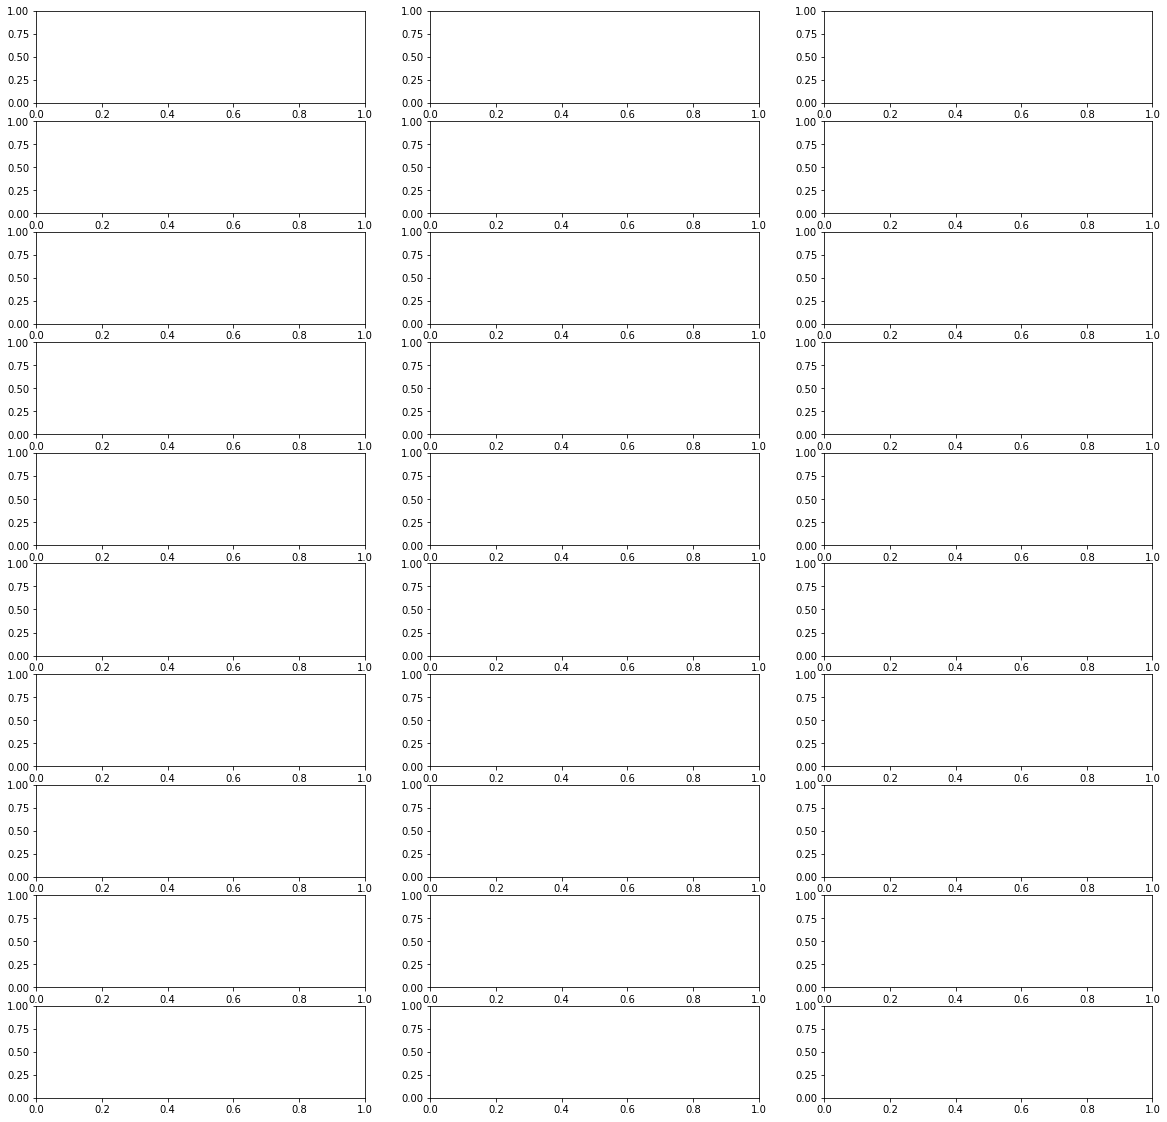

In [ ]:
validate(model,valid_loader_source, valid_loader_target, GRID_SIZE, visualize=True)

In [ ]:
for param in model.parameters():
  print(param.data)

In [ ]:
print(Trainset_target[0])

In [ ]:
#perform cumsum operation on a 2d batch of inputs
#takes in grid tensors of shape batch x 2 x grid x grid 
#return grid tensors of shape batch x 2 x grid x grid 
def cumsum(grid):

  Integrated_grid_x = torch.cumsum(grid[:,0], dim = 2)
  Integrated_grid_y = torch.cumsum(grid[:,1], dim = 1)
  Integrated_grid = torch.stack([Integrated_grid_x, Integrated_grid_y])
  return Integrated_grid

grid = np.ones([8,2,8,8])
grid = torch.tensor(grid)
print(cumsum(grid))

tensor([[[[1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          ...,
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.]],

         [[1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          ...,
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.]],

         [[1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          ...,
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.]],

         ...,

         [[1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          [1., 2., 3.,  ..., 6., 7., 8.],
          ...,
          [1., 2., 3.,  ..., 6., 7., 

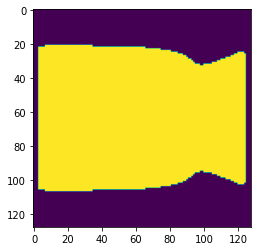

AttributeError: ignored